In [5]:
# Библиотеки для обработки табличных данных
import pandas as pd
import numpy as np

# Библиотеки для визуализации графиков и изображений/
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Библиотеки для обучения моделей
import torch
from sklearn.model_selection import train_test_split

# Библиотека для работы с операционной системой
import os
import glob

# Библиотека для парсинга XML-файлов
import xml.etree.ElementTree as ET 

#Вспомогательные библиотеки
from tqdm.auto import tqdm
import shutil as sh
import warnings

# Игнорируем возникающие предупреждения
warnings.filterwarnings('ignore')

/home/estaid/miniconda3/envs/DL/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Проверим, что нам доступна видеокарта
print(torch.cuda.is_available())
# Узнаем название видеокарты
print(torch.cuda.get_device_name(0))
## True
## Tesla T4

True
NVIDIA GeForce RTX 4070 SUPER


In [11]:
# Путь до папки с датасетом
DATASET_PATH = "data"
# Путь до папки с аннотациями
ANNOTATIONS_PATH = os.path.join(DATASET_PATH, "annotations")
# Путь до папки с изображениями
IMAGES_PATH = os.path.join(DATASET_PATH, "images")

print(ANNOTATIONS_PATH)
print(IMAGES_PATH)

data/annotations
data/images


Image shape: (398, 530, 3)


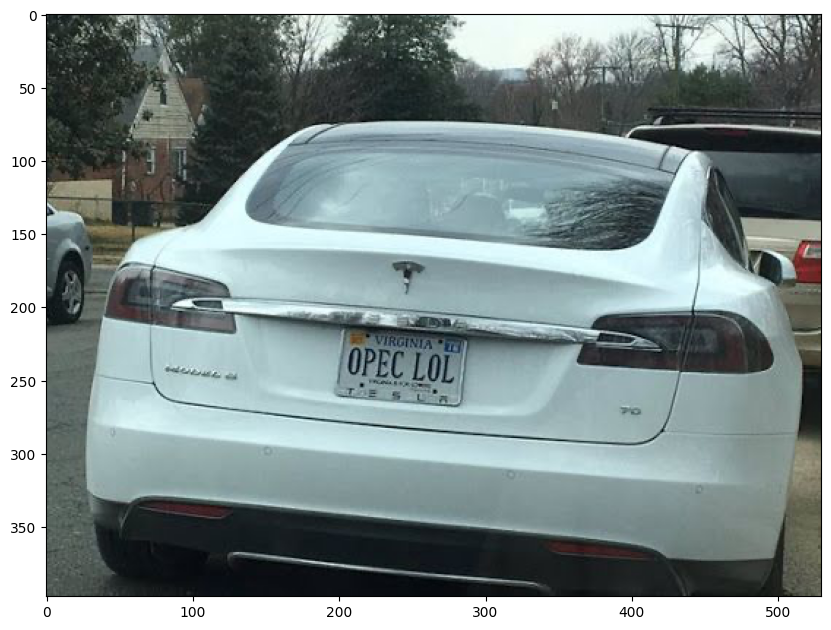

In [12]:
# Составляем путь до файла: /путь/до/папки/имя_изображения.png
image_filename = 'Cars129.png'
image_path = os.path.join(IMAGES_PATH, image_filename)
# Читаем изображение
img = plt.imread(image_path)
# Создаём фигуру и координатную плоскость
fig, ax = plt.subplots(figsize=(10, 8))
# Выводим изображение на экран
ax.imshow(img);
# Выводим размер изображения
print('Image shape: {}'.format(img.shape))

In [13]:
print(img)

[[[0.2901961  0.3254902  0.32156864]
  [0.16470589 0.2        0.19607843]
  [0.10588235 0.14117648 0.13725491]
  ...
  [0.20784314 0.23137255 0.21568628]
  [0.27450982 0.29411766 0.2784314 ]
  [0.29803923 0.31764707 0.3019608 ]]

 [[0.3019608  0.3372549  0.33333334]
  [0.19215687 0.22745098 0.22352941]
  [0.10588235 0.14117648 0.13725491]
  ...
  [0.2627451  0.28627452 0.27058825]
  [0.63529414 0.654902   0.6392157 ]
  [0.43137255 0.4509804  0.43529412]]

 [[0.21568628 0.2509804  0.24705882]
  [0.14509805 0.18039216 0.1764706 ]
  [0.09803922 0.13333334 0.12941177]
  ...
  [0.2509804  0.27450982 0.25882354]
  [0.52156866 0.5411765  0.5254902 ]
  [0.3019608  0.32156864 0.30588236]]

 ...

 [[0.3254902  0.36078432 0.34117648]
  [0.34117648 0.3764706  0.35686275]
  [0.33333334 0.36862746 0.34901962]
  ...
  [0.37254903 0.3882353  0.32941177]
  [0.3882353  0.39215687 0.3372549 ]
  [0.3882353  0.39215687 0.3372549 ]]

 [[0.29411766 0.32941177 0.30980393]
  [0.30588236 0.34117648 0.32156864]


In [14]:
# Прочитаем один из файлов с аннотациями и посмотрим на его содержимое
with open(os.path.join(ANNOTATIONS_PATH, 'Cars129.xml')) as f:
    print(f.read())


<annotation>
    <folder>images</folder>
    <filename>Cars129.png</filename>
    <size>
        <width>530</width>
        <height>398</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>licence</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>204</xmin>
            <ymin>213</ymin>
            <xmax>282</xmax>
            <ymax>267</ymax>
        </bndbox>
    </object>
</annotation>


In [16]:
# Инициализируем словарь, на основе которого затем создадим DataFrame
df_dict = {
    "filename":[], "xmin":[], "ymin":[],   
    "xmax":[],"ymax":[], "name":[],    
    "width":[], "height":[],
}

# Создаём цикл по всем аннотациям 
for annotation in glob.glob(ANNOTATIONS_PATH+"/*.xml"):
    # Читаем XML-файл с аннотацией
    tree = ET.parse(annotation)
    # Находим тег, соответствующий имени файла
    filename = tree.find('filename').text
    # Создаём цикл по всем элементам XML-файла
    for elem in tree.iter():
        # Извлекаем из аннотации информацию о размере изображения — ширину и высоту
        if 'size' in elem.tag:
            for attr in list(elem):
                if 'width' in attr.tag: 
                    width = int(round(float(attr.text)))
                if 'height' in attr.tag:
                    height = int(round(float(attr.text)))    
        # Извлекаем информацию об изображении — имя класса и информацию о координатах bounding box
        if 'object' in elem.tag:
            for attr in list(elem):
                if 'name' in attr.tag:
                    name = attr.text                 
                    df_dict['name'] += [name]
                    df_dict['width'] += [width]
                    df_dict['height'] += [height] 
                    df_dict['filename'] += [filename]


                if 'bndbox' in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                            df_dict['xmin'] += [xmin]
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            df_dict['ymin'] += [ymin]                                
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            df_dict['xmax'] += [xmax]                                
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            df_dict['ymax'] += [ymax]

In [17]:
df = pd.DataFrame(df_dict)
df.head()

,filename,xmin,ymin,xmax,ymax,name,width,height
0,Cars50.png,116,55,525,262,licence,590,350
1,Cars89.png,307,206,345,221,licence,400,262
2,Cars89.png,227,222,253,230,licence,400,262
3,Cars155.png,150,177,203,190,licence,400,267
4,Cars156.png,114,78,230,102,licence,400,200


In [18]:
print('Data shape: {}'.format(df.shape))
print('Count of unique images: {}'.format(df['filename'].nunique()))
print('Count of classes: {}'.format(df['name'].unique()))

Data shape: (471, 8)
Count of unique images: 433
Count of classes: ['licence']


[204] [213] [78] [54]


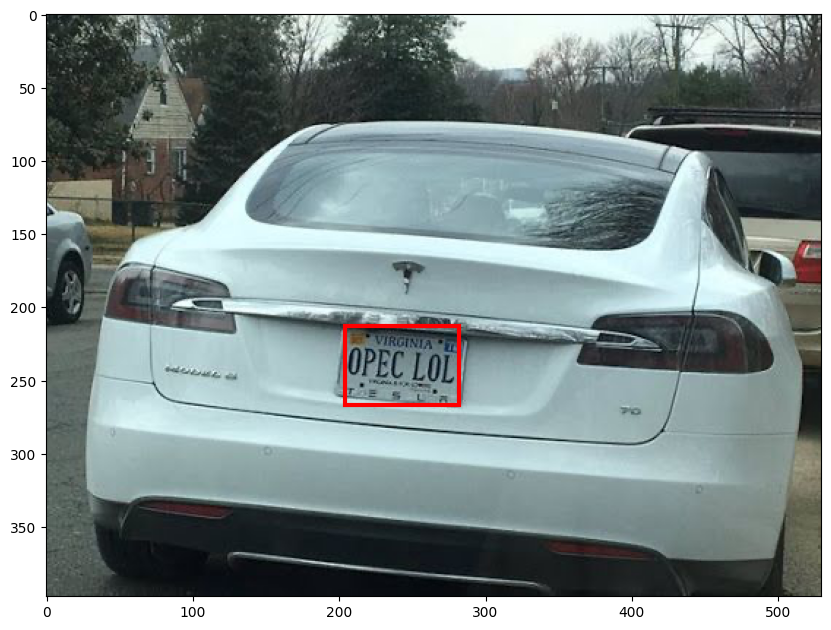

In [19]:
# Составляем путь до файла — /путь/до/папки/имя_изображения.png
image_filename = 'Cars129.png'
image_path = os.path.join(IMAGES_PATH, image_filename)
# Читаем изображение
img = plt.imread(image_path)
# Создаём фигуру и координатную плоскость
fig, ax = plt.subplots(figsize=(10, 8))
# Выводим изображение на экран
ax.imshow(img);

# Находим индекс картинки в DataFrame
image_idx = df[df['filename'] == image_filename].index

# Находим координаты левой нижней точки
x_min = df.loc[image_idx, 'xmin'].values
y_min = df.loc[image_idx, 'ymin'].values
# Находим ширину и высоту рамки
box_width = (df.loc[image_idx, 'xmax'] - df.loc[image_idx, 'xmin']).values
box_height = (df.loc[image_idx, 'ymax'] - df.loc[image_idx, 'ymin']).values
print(x_min, y_min, box_width, box_height)

# Так как ограничивающих прямоугольников может быть несколько, создаём цикл по всем.
for i in range(len(image_idx)):
    # Строим прямоугольник
    rect = patches.Rectangle(
        (x_min[i], y_min[i]), #координаты опорной точки
        box_width[i], #ширина прямоугольника
        box_height[i], #высота прямоугольника
        linewidth=3, #ширина линии
        edgecolor='r', #цвет
        facecolor='none' #заливка (none — отсутствует)
    )
    # Накладываем прямоугольник поверх изображения
    ax.add_patch(rect);